<a href="https://colab.research.google.com/github/Bnibling/Thinkful_Data_Science_Immersion_Portfolio/blob/main/NLP_Challenge_Diaster_Tweets_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Challenge- Diaster Tweets Text Analysis

The following notebook explores, cleans and attempts to model with various classifers the data provided by Kaggle's [Natural Language Processing with Disaster Tweets Competition](https://www.kaggle.com/c/nlp-getting-started/data) which labels 7613 tweets as according during a diaster or not.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import collections

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
train_data = '/content/drive/MyDrive/Thinkful/NLP/nlp-getting-started/train.csv'

train_df = pd.read_csv(train_data)

# EDA

In [5]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.shape

(7613, 5)

In [7]:
train_df.isnull().sum().sort_values(ascending=False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

In [8]:
train_df = train_df.drop_duplicates(subset=['text', 'target'], keep='first')
train_df.shape

(7521, 5)

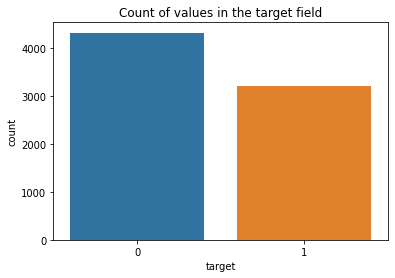

In [9]:
sns.countplot(x=train_df['target'])
plt.title('Count of values in the target field')
plt.show()

There is a class imbalance in the target feature.

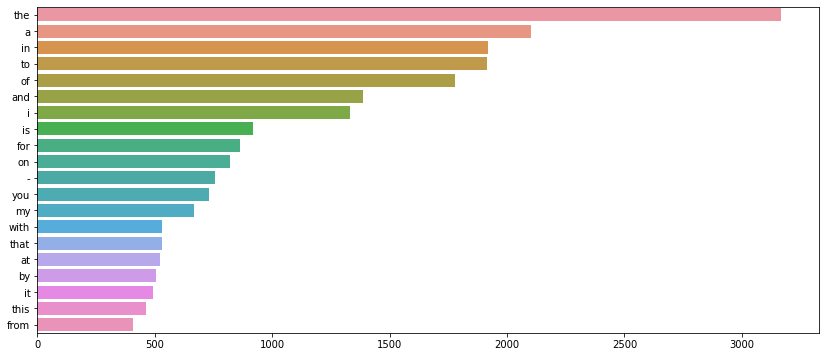

In [10]:
vocabulary_list = pd.Series([word.lower().strip() for sent in train_df['text'].str.split() for word in sent])
top_20_words = vocabulary_list.value_counts().head(20)

plt.figure(figsize=(14,6))
sns.barplot(x=top_20_words, y=top_20_words.index)
plt.show()

In [11]:
len(set(vocabulary_list))

27983

#Text Cleaning

The following code will do the following:

* Convert all characters to lower case
* Remove all numeric characters
* Remove all punctuation
* Remove common words
* Lemmatize based on POS tag

In [12]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def clean_text(text):
  text = text.lower()
  text = re.sub('[0-9]', '', text)
  text = re.sub('[^\w\s]', '', text)
  tokens = word_tokenize(text)
  tokens = [token for token in tokens if token not in stop]
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
  text = ' '.join(tokens)
  
  return text

In [13]:
train_df['text_cleaned'] = train_df['text'].apply(clean_text)

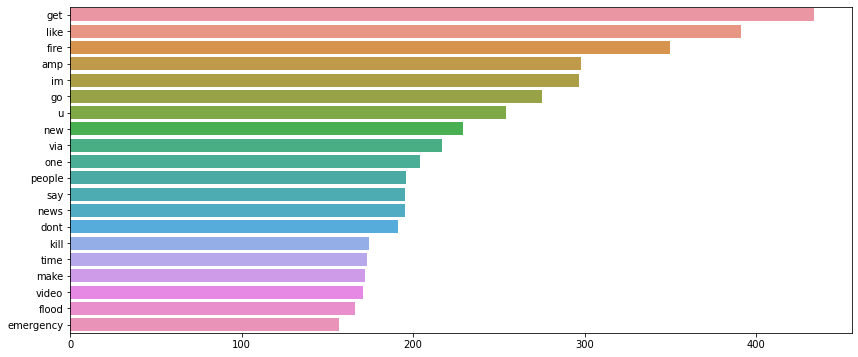

In [14]:
clean_vocabulary_list = pd.Series([word.lower().strip() for sent in train_df['text_cleaned'].str.split() for word in sent])
top_20_cleanwords = clean_vocabulary_list.value_counts().head(20)

plt.figure(figsize=(14,6))
sns.barplot(x=top_20_cleanwords, y=top_20_cleanwords.index)
plt.show()

In [15]:
len(set(clean_vocabulary_list))

19523

The total number of words has decreased by nearly 10,000 after cleaning. From the list of top 20 words, further cleaning could also be done to potentially increase the performance of the models below.

#Data Modeling

In [16]:
X = train_df['text_cleaned']
y = train_df['target']

In [28]:
def build_model(X, y, vectorizer=CountVectorizer(), classifier=RandomForestClassifier(random_state=42)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)
                ])
  model.fit(X_train, y_train)
  print(f'{model[0].__class__.__name__} {model[1].__class__.__name__} Model Analysis \n')
  print(f'Training Score:{model.score(X_train, y_train):.3f}')
  print(f'Test Score:{model.score(X_test, y_test):.3f}\n')
  print(classification_report(y_test, model.predict(X_test)))
  plot_confusion_matrix(model, X_test, y_test, values_format='.0f')
  plt.show()
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
  print(f'{model[0].__class__.__name__} {model[1].__class__.__name__} AVG Training F1 scores: {scores.mean():.3f}, {scores.std():.3f}')

  return model

CountVectorizer LogisticRegression Model Analysis 

Training Score:0.966
Test Score:0.790

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       863
           1       0.79      0.69      0.74       642

    accuracy                           0.79      1505
   macro avg       0.79      0.78      0.78      1505
weighted avg       0.79      0.79      0.79      1505



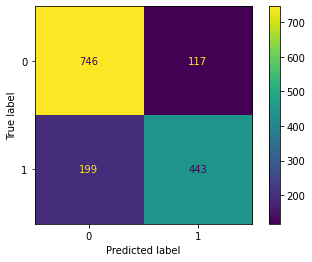

CountVectorizer LogisticRegression AVG Training F1 scores: 0.779, 0.011


In [29]:
bow_lr = build_model(X, y, CountVectorizer(), LogisticRegression(random_state=42))

CountVectorizer RandomForestClassifier Model Analysis 

Training Score:0.997
Test Score:0.786

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       863
           1       0.83      0.63      0.72       642

    accuracy                           0.79      1505
   macro avg       0.80      0.77      0.77      1505
weighted avg       0.79      0.79      0.78      1505



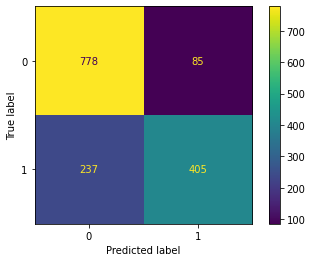

CountVectorizer RandomForestClassifier AVG Training F1 scores: 0.770, 0.014


In [30]:
bow_rfc = build_model(X, y, CountVectorizer(), RandomForestClassifier(random_state=42))

CountVectorizer GradientBoostingClassifier Model Analysis 

Training Score:0.775
Test Score:0.748

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       863
           1       0.86      0.48      0.62       642

    accuracy                           0.75      1505
   macro avg       0.79      0.71      0.72      1505
weighted avg       0.78      0.75      0.73      1505



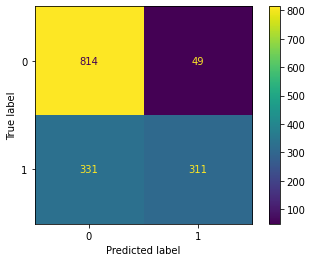

CountVectorizer GradientBoostingClassifier AVG Training F1 scores: 0.709, 0.016


In [35]:
bow_gbc = build_model(X, y, CountVectorizer(), GradientBoostingClassifier(random_state=42))

TfidfVectorizer LogisticRegression Model Analysis 

Training Score:0.894
Test Score:0.795

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       863
           1       0.81      0.68      0.74       642

    accuracy                           0.79      1505
   macro avg       0.80      0.78      0.78      1505
weighted avg       0.80      0.79      0.79      1505



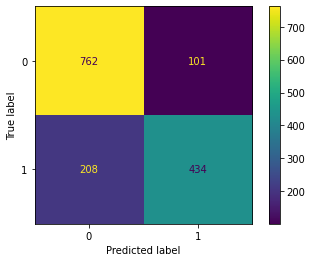

TfidfVectorizer LogisticRegression AVG Training F1 scores: 0.785, 0.011


In [31]:
tfidf_lr = build_model(X, y, TfidfVectorizer(), LogisticRegression(random_state=42))

TfidfVectorizer RandomForestClassifier Model Analysis 

Training Score:0.997
Test Score:0.779

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       863
           1       0.79      0.66      0.72       642

    accuracy                           0.78      1505
   macro avg       0.78      0.76      0.77      1505
weighted avg       0.78      0.78      0.78      1505



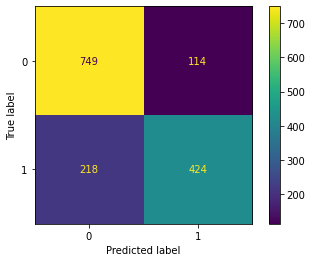

TfidfVectorizer RandomForestClassifier AVG Training F1 scores: 0.772, 0.017


In [32]:
tfidf_rfc = build_model(X, y, TfidfVectorizer(), RandomForestClassifier(random_state=42))

TfidfVectorizer GradientBoostingClassifier Model Analysis 

Training Score:0.782
Test Score:0.748

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       863
           1       0.86      0.49      0.63       642

    accuracy                           0.75      1505
   macro avg       0.78      0.72      0.72      1505
weighted avg       0.77      0.75      0.73      1505



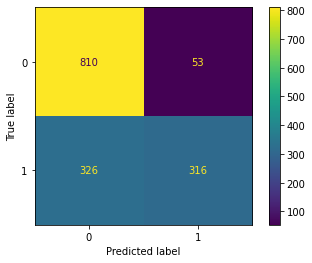

TfidfVectorizer GradientBoostingClassifier AVG Training F1 scores: 0.709, 0.015


In [34]:
tfidf_gbc = build_model(X, y, TfidfVectorizer(), GradientBoostingClassifier(random_state=42))

There is a class imbalance in the target data that is causing the models to overfit the training sets. The best model that appears to handle this issue (at default parameters) is GradientBoostingClassifier using TfidfVectorize, although at a cost of test performance. If overfitting isn't an issue then good old LogisticRegression with TfidfVectorizer appears to have the best test scores of all the models. Of course, parameter optimization would need to be performed in order to correctly determine the best model to use going forward.